Fitting simple functions with Neural Networks
========

Rupert Brooks August 2018

In this notebook we explore using neural networks to fit scalar functions over 1 and 2 dimensional domains.

Preliminaries
-------

In [185]:
%%javascript 
_=IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;   }

<IPython.core.display.Javascript object>

In [18]:
from scipy.special import gamma
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv1D,BatchNormalization
from mpl_toolkits.mplot3d import axes3d

Simple 1D function
----
Consider the gamma function $\Gamma(x)$.  This function is also known as the generalized factorial function, since $\Gamma(x+1)=x!$ for positive integers.  Over the domain 0 to 4, $\Gamma(x+1)$ is quite well behaved.

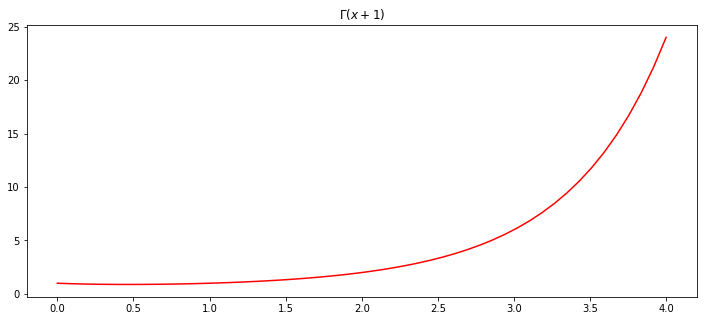

In [49]:
x=np.linspace(0,4,50)
y=gamma(x+1)
fig=plt.figure(figsize=(12,5))
_=plt.plot(x,y,'r-')
_=plt.title("$\Gamma(x+1)$")

The gamma function can be approximated fairly easily by low order polynomials.  Let us fit the function to exact data, and compute the approximation on exactly the same points as were fed to it. This is a particularly easy case. 

In [110]:
def make_data_case_1():
    xtest=np.linspace(0,4,50)
    ytest=gamma(x+1)
    xtrain=xtest
    ytrain=ytest
    return (xtrain,ytrain),(xtest,ytest)


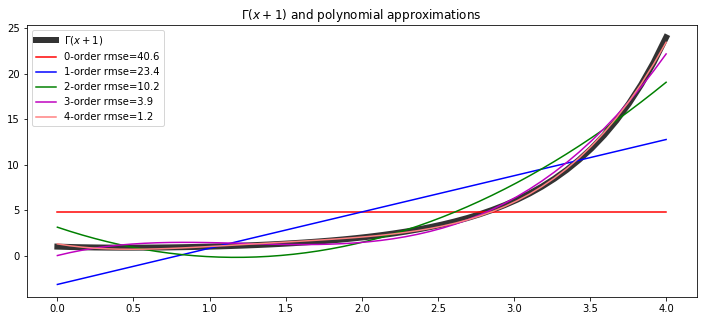

In [112]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_1()
fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and polynomial approximations")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for d in [0,1,2,3,4]:
    y_approx=np.polyval(np.polyfit(xtrain,ytrain,d),xtest)
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(x,y_approx,color=_colors[d%len(_colors)],label="%d-order rmse=%3.1f"%(d,rmse))
_=plt.legend()

Lets make it a bit more interesting - let's not use exactly the same points for training and testing. Instead, pick training points halfway in between the testing points.

In [114]:
def make_data_case_2():
    xtest=np.linspace(0,4,50)
    ytest=gamma(x+1)
    xtrain=(xtest[:-1]+xtest[1:])*0.5
    ytrain=gamma(xtrain+1)
    return (xtrain,ytrain),(xtest,ytest)


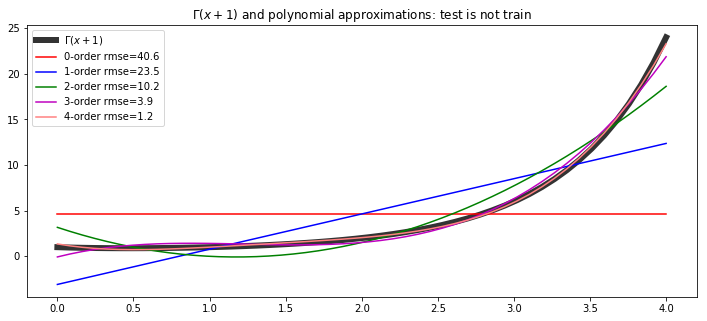

In [115]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_2()
fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and polynomial approximations: test is not train")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for d in [0,1,2,3,4]:
    y_approx=np.polyval(np.polyfit(xtrain,ytrain,d),xtest)
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[d%len(_colors)],label="%d-order rmse=%3.1f"%(d,rmse))
_=plt.legend()

Lets add some Gaussian noise to the training data

In [116]:
def make_data_case_3():
    (xtrain,ytrain),(xtest,ytest)=make_data_case_2()
    ytrain+=np.random.standard_normal(ytrain.shape)*0.5
    return (xtrain,ytrain),(xtest,ytest)


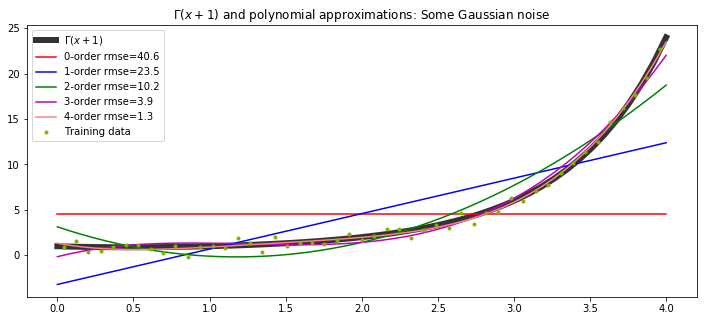

In [117]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_3()
fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and polynomial approximations: Some Gaussian noise")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for d in [0,1,2,3,4]:
    y_approx=np.polyval(np.polyfit(xtrain,ytrain,d),xtest)
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[d%len(_colors)],label="%d-order rmse=%3.1f"%(d,rmse))
_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()

Lets drop 0.5 off the training data at both ends, so that some extrapolation is required, and lets drop the training data from 2.5 to 3.0, to leave a large interpolation patch.

In [118]:
def make_data_case_4():
    (xtrain,ytrain),(xtest,ytest)=make_data_case_2()
    def criterion(x):
        if x <= 0.5 or x >= 3.5:
            return False
        if x >= 2.5 and x <= 3.0:
            return False
        return True
    xtrain=xtrain[np.array(list(map(criterion,xtrain)))]
    ytrain=gamma(xtrain+1)+np.random.standard_normal(xtrain.shape)*0.5
    return (xtrain,ytrain),(xtest,ytest)


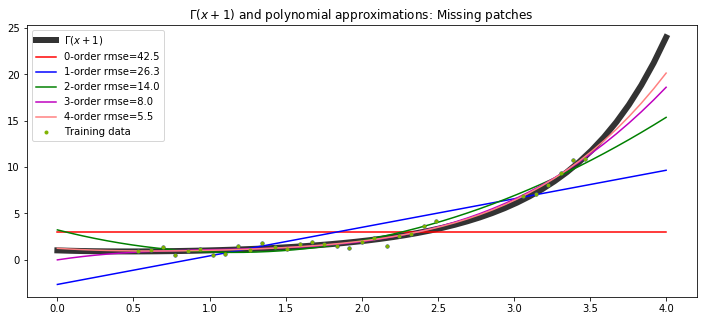

In [120]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_4()
fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and polynomial approximations: Missing patches")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for d in [0,1,2,3,4]:
    y_approx=np.polyval(np.polyfit(xtrain,ytrain,d),xtest)
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[d%len(_colors)],label="%d-order rmse=%3.1f"%(d,rmse))
_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()
stored_ylim=plt.ylim()  # store the y limits - we will need them later

The exact results are quite dependent on the random noise in the data, for different runs of this notebook, different results will be obtained.  Sometimes the performance even starts to deteriorate with the 4th order polynomial.  Increasing it further, it deteriorates quickly due to overfitting, particularly in the extrapolated areas at the ends.

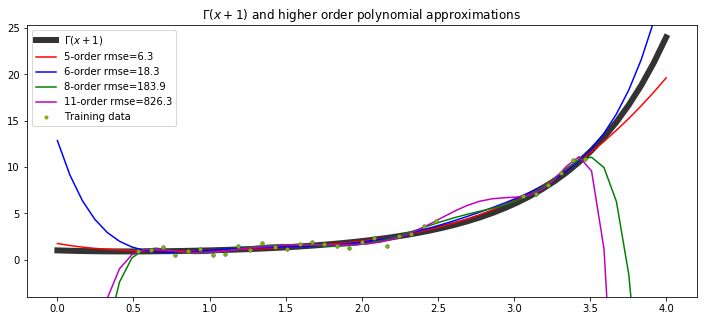

In [121]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_4()
fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and higher order polynomial approximations")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for i,d in enumerate([5,6,8,11]):
    y_approx=np.polyval(np.polyfit(xtrain,ytrain,d),xtest)
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[i%len(_colors)],label="%d-order rmse=%3.1f"%(d,rmse))
_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()
_=plt.ylim(stored_ylim)

We can do a similar fitting with a neural network.  We will work through the same stages of complexity as with the polynomials.  There are many architectures that could be explored, the following example uses one hidden layer of size 8 for a total of 97 parameters - this is about an order of magnitude more than the number of parameters we are using with the polynomials.

This size of network was chosen fairly arbitrarily - results are also good with an additional hidden layer, although batch normalization seems essential in that case for good convergence.  Below about 5 elements in the inner layers, the results seem very poor.

In [179]:
model = Sequential()
model.add(Dense(8, activation='relu', kernel_initializer="normal", input_dim=1))
#model.add(Dense(8, activation='relu', kernel_initializer="normal"))
#model.add(BatchNormalization())
model.add(Dense(8, activation='relu', kernel_initializer="normal"))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam',
              loss='mean_squared_error')
model.summary()
initial_weights=model.get_weights()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_68 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


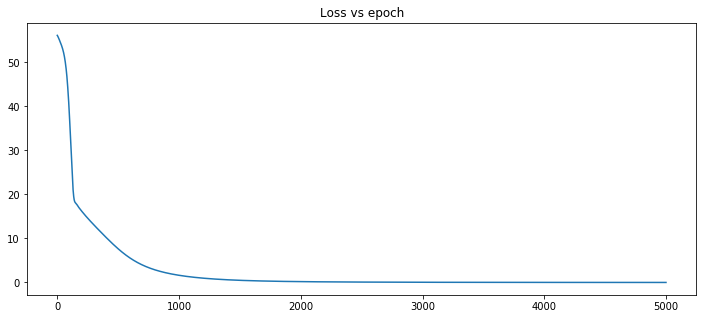

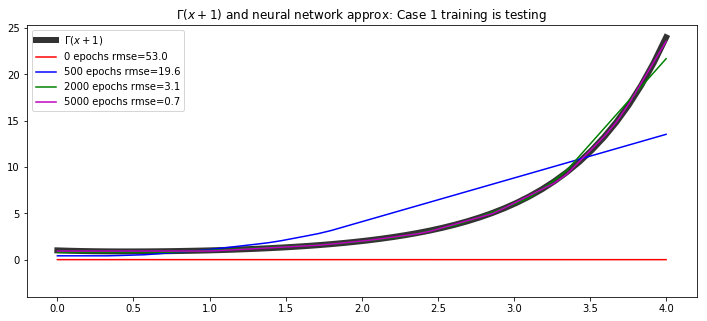

In [181]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_1()
model.set_weights(initial_weights)
schedule=[0,500,2000,5000]
outputs=[]
loss=[]
epochsperformed=0
for s in schedule:
    if s>0:
        history=model.fit(xtrain, ytrain, epochs=s-epochsperformed, shuffle=True, batch_size=50, verbose=0)
        loss+=history.history['loss']
    epochsperformed=s
    outputs.append(model.predict(xtest))

fig=plt.figure(figsize=(12,5))
plt.title("Loss vs epoch")
_=plt.plot(loss)
plt.show()

fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and neural network approx: Case 1 training is testing")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for i,s in enumerate(schedule):
    y_approx=outputs[i].ravel()
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[i%len(_colors)],label="%d epochs rmse=%3.1f"%(s,rmse))
#_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()
_=plt.ylim(stored_ylim)


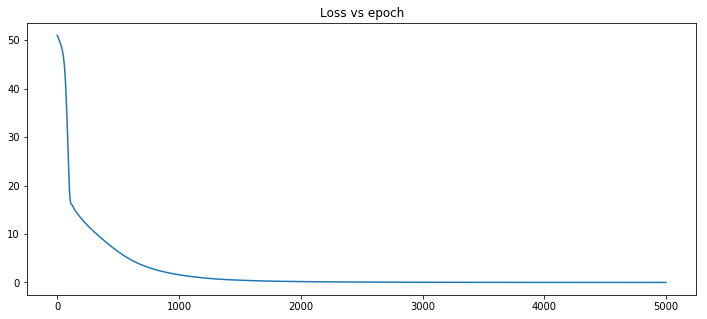

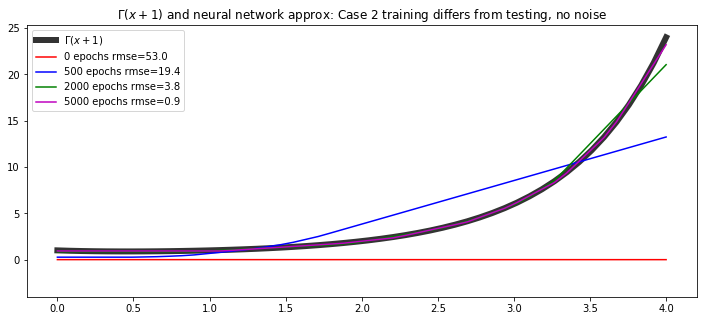

In [182]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_2()
model.set_weights(initial_weights)
schedule=[0,500,2000,5000]
outputs=[]
loss=[]
epochsperformed=0
for s in schedule:
    if s>0:
        history=model.fit(xtrain, ytrain, epochs=s-epochsperformed, shuffle=True, batch_size=50, verbose=0)
        loss+=history.history['loss']
    epochsperformed=s
    outputs.append(model.predict(xtest))

fig=plt.figure(figsize=(12,5))
plt.title("Loss vs epoch")
_=plt.plot(loss)
plt.show()

fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and neural network approx: Case 2 training differs from testing, no noise")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for i,s in enumerate(schedule):
    y_approx=outputs[i].ravel()
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[i%len(_colors)],label="%d epochs rmse=%3.1f"%(s,rmse))
#_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()
_=plt.ylim(stored_ylim)


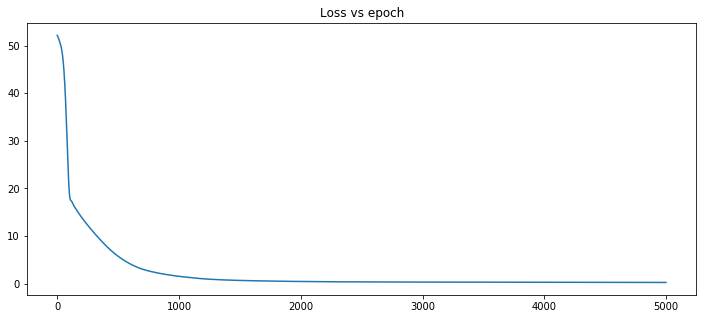

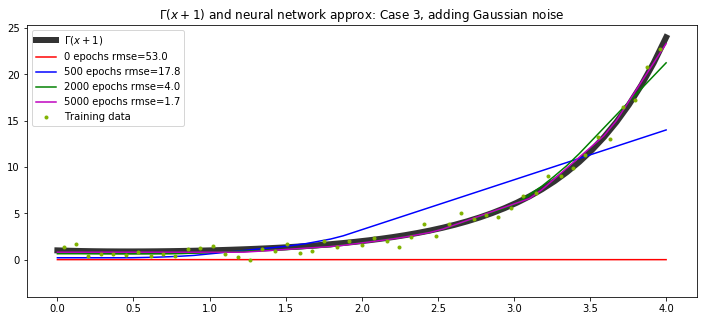

In [183]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_3()
model.set_weights(initial_weights)
schedule=[0,500,2000,5000]
outputs=[]
loss=[]
epochsperformed=0
for s in schedule:
    if s>0:
        history=model.fit(xtrain, ytrain, epochs=s-epochsperformed, shuffle=True, batch_size=50, verbose=0)
        loss+=history.history['loss']
    epochsperformed=s
    outputs.append(model.predict(xtest))

fig=plt.figure(figsize=(12,5))
plt.title("Loss vs epoch")
_=plt.plot(loss)
plt.show()

fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and neural network approx: Case 3, adding Gaussian noise")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for i,s in enumerate(schedule):
    y_approx=outputs[i].ravel()
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[i%len(_colors)],label="%d epochs rmse=%3.1f"%(s,rmse))
_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()
_=plt.ylim(stored_ylim)


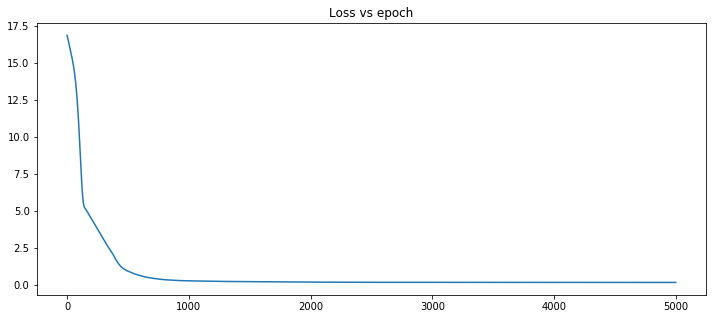

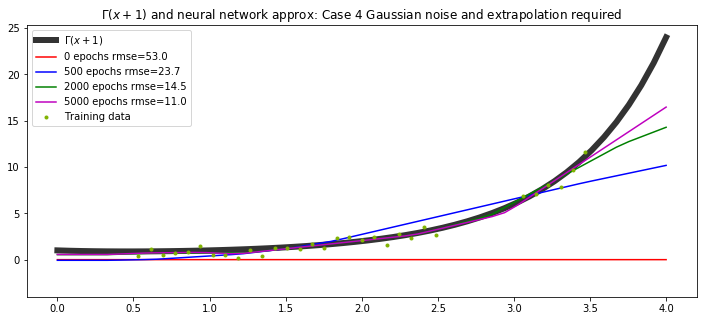

In [184]:
(xtrain,ytrain),(xtest,ytest)=make_data_case_4()
model.set_weights(initial_weights)
schedule=[0,500,2000,5000]
outputs=[]
loss=[]
epochsperformed=0
for s in schedule:
    if s>0:
        history=model.fit(xtrain, ytrain, epochs=s-epochsperformed, shuffle=True, batch_size=50, verbose=0)
        loss+=history.history['loss']
    epochsperformed=s
    outputs.append(model.predict(xtest))

fig=plt.figure(figsize=(12,5))
plt.title("Loss vs epoch")
_=plt.plot(loss)
plt.show()

fig=plt.figure(figsize=(12,5))
_=plt.title("$\Gamma(x+1)$ and neural network approx: Case 4 Gaussian noise and extrapolation required")
_colors=['r','b','g','m',(1.0,0.5,0.5)]
_=plt.plot(x,y,label="$\Gamma(x+1)$",linewidth=6,color=(0.2,0.2,0.2))
for i,s in enumerate(schedule):
    y_approx=outputs[i].ravel()
    err=y_approx-ytest
    rmse=np.sqrt(np.sum(err**2))
    _=plt.plot(xtest,y_approx,color=_colors[i%len(_colors)],label="%d epochs rmse=%3.1f"%(s,rmse))
_=plt.plot(xtrain,ytrain,'.',color=(0.5,0.7,0),label="Training data")
_=plt.legend()
_=plt.ylim(stored_ylim)


Conclusion
-----

This example shows how to use a simple neural network for a regression problem.  For a problem of this simplicity, the neural network approach is probably overkill.  While the performance is similar to the best performing polynomial model, the system does not seem to break down as badly due to overfitting.

-------------


<CENTER>    End of Main  </CENTER>


---------------



The following is incomplete notes on a 2D example.

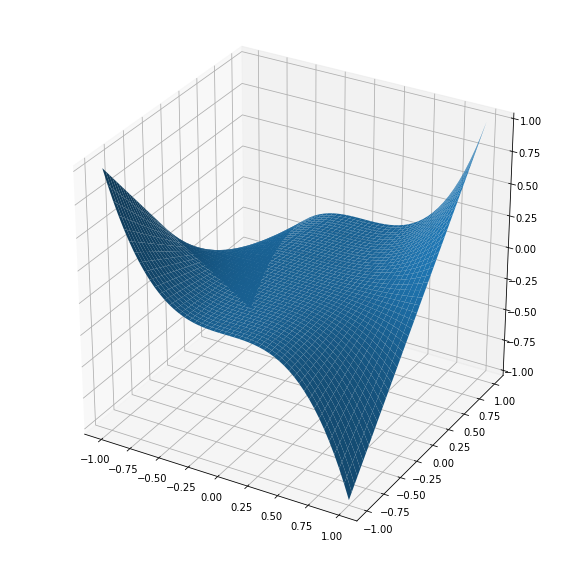

In [25]:
xs,ys=np.meshgrid(np.linspace(-1,1,50),np.linspace(-1,1,50))
zs=np.multiply(xs,np.multiply(xs,np.multiply(xs,ys)))
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
_=ax.plot_surface(xs,ys,zs)


In [40]:
model2d = Sequential()
model2d.add(Dense(16, activation='relu', kernel_initializer="normal", input_dim=2))
model2d.add(Dense(16, activation='relu', kernel_initializer="normal"))
model2d.add(Dense(1, activation='linear'))
model2d.compile(optimizer='adam',
              loss='mean_squared_error')
model2d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [41]:
xstrain=np.array(list(zip(xs.ravel(),ys.ravel())))
ystrain=zs.ravel();
# Train the model, iterating on the data in batches of 32 samples
model2d.fit(xstrain, ystrain, epochs=200, batch_size=50, verbose=0)


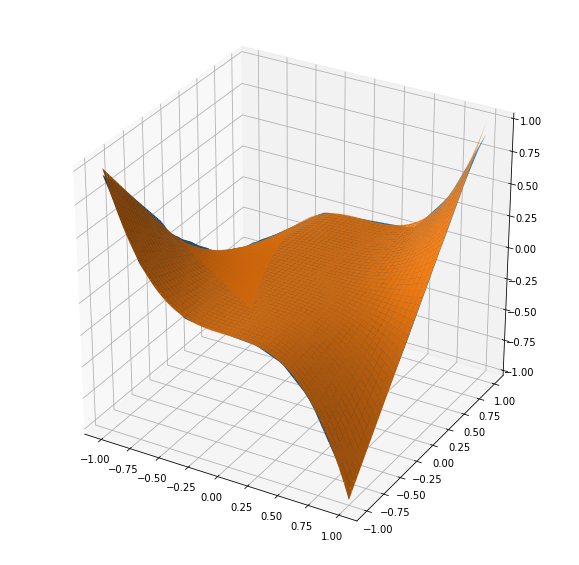

In [42]:

zsresult=model2d.predict(xstrain)

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
_=ax.plot_surface(xs,ys,zsresult.reshape(zs.shape))
_=ax.plot_surface(xs,ys,zs)

